# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activation, batch, optimizers)
### LECTURE: CodeChallenge: Minibatch size in the wine dataset
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202401

In [51]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for timing computations
import time

# for data visualization
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# Import and process the data

In [52]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

In [53]:
data.keys()

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

<Axes: ylabel='Frequency'>

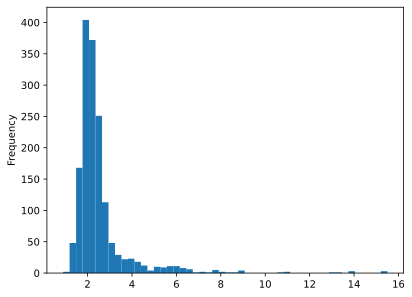

In [54]:
data["residual sugar"].plot.hist(bins=50)

In [55]:


# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('residual sugar')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# Re-organize the data: train/test in DataLoaders

In [56]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['residual sugar'].values ).float()
labels = labels[:,None] # transform to matrix

In [57]:
# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.15)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data,train_labels)
test_dataDataset  = TensorDataset(test_data,test_labels)

In [58]:
test_loader = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])
train_loader = DataLoader(train_dataDataset, batch_size=64, shuffle=True, drop_last=True)

# Now for the DL part

In [59]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)
  
  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) ) # fully connected
    x = F.relu( self.fc2(x) )
    return self.output(x)

# Train the model

In [60]:
# a function that trains the model

# global parameter
numepochs = 1000

def trainTheModel():

  # loss function and optimizer
  lossfun = nn.MSELoss()
  optimizer = torch.optim.SGD(winenet.parameters(),lr=.01)

  # initialize losses
  trainLoss = torch.zeros(numepochs)
  testLoss  = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # switch on training mode
    winenet.train()

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    #trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    trainLoss[epochi] = np.mean(batchLoss)    #(predictions-y).pow(2).mean()

    # test accuracy
    winenet.eval()
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testLoss[epochi] = lossfun(yHat,y).item()
  
  # function output
  return trainLoss,testLoss#,losses

# Now for the experiment

In [61]:
# This cell takes ~15 mins


winenet = ANNwine()
trainLoss,testLoss = trainTheModel()


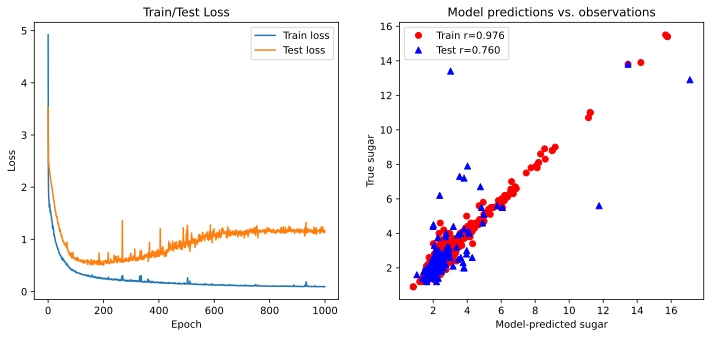

In [62]:
# plot some results
fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(trainLoss, label='Train loss')
ax[0].set_title('Train/Test Loss')
ax[0].plot(testLoss, label='Test loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# show predictions and real values
yHatTrain = winenet(train_data)
yHatTest  = winenet(test_data)

ax[1].plot(yHatTrain.detach(),train_labels,'ro')
ax[1].plot(yHatTest.detach(),test_labels,'b^')
ax[1].set_xlabel('Model-predicted sugar')
ax[1].set_ylabel('True sugar')
ax[1].set_title('Model predictions vs. observations')

# correlations between predictions and outputs
corrTrain = np.corrcoef(yHatTrain.detach().T,train_labels.T)[1,0]
corrTest  = np.corrcoef(yHatTest.detach().T, test_labels.T)[1,0]
ax[1].legend([ f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}' ])

plt.show()



In [63]:
yHatTrain.detach().T.shape

torch.Size([1, 1357])

In [64]:
train_labels.T

tensor([[4.0000, 1.3000, 2.5000,  ..., 1.7000, 1.8000, 2.3000]])

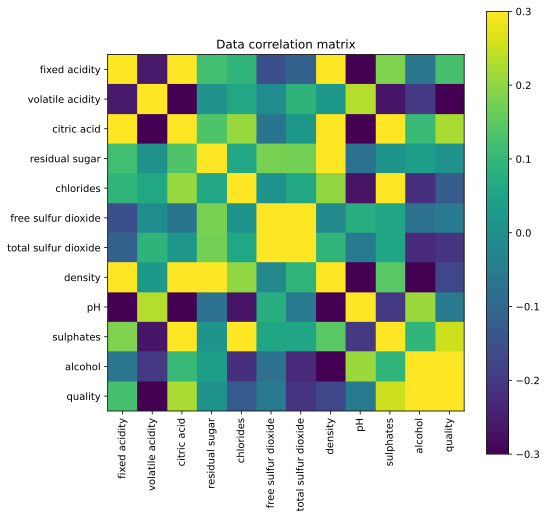

In [65]:
# Inspect the correlation matrix
fig = plt.figure(figsize=(8,8))

plt.imshow(np.corrcoef(data.T),vmin=-.3,vmax=.3)
plt.xticks(range(len(data.keys())),labels=data.keys(),rotation=90)
plt.yticks(range(len(data.keys())),labels=data.keys())
plt.colorbar()
plt.title('Data correlation matrix')
plt.show()

# Additional explorations

In [66]:
# 1) There is another regularization technique called "early stopping," which simply means to stop training the model
#    earlier than the number of epochs you specified. Early stopping is used when the test accuracy starts to decrease
#    with increased training. Do you think that early stopping would be beneficial here? How many epochs would you train?
# 
# 2) The training loop computes the losses, but those aren't plotted. Create an additional subplot to show the losses
#    in a similar fashion as the accuracy. Does that plot provide any additional insights into the effects of minibatch
#    size, beyond what we can already learn from the accuracy plots.
# 